Task 1

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Load data

sa2 = gpd.read_file("SA2_2021/SA2_2021_AUST_GDA2020.shp")
sa2 = sa2[sa2['GCC_NAME21'] == "Greater Sydney"]

catchments_primary = gpd.read_file('catchments/catchments_primary.shp')
catchments_secondary = gpd.read_file("catchments/catchments_secondary.shp")
catchments_future = gpd.read_file("catchments/catchments_future.shp")

business = pd.read_csv("Businesses.csv")
income = pd.read_csv("Income.csv")
population = pd.read_csv("Population.csv")
stops = pd.read_csv("Stops.txt",quotechar='"')
polls = pd.read_csv('PollingPlaces2019.csv')

In [3]:
# Convert Point and Polygons

#Define SRID
srid = 4283

stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)
stops = stops.drop(columns=['stop_lon', 'stop_lat'])
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

polls['geom'] = gpd.points_from_xy(polls.longitude, polls.latitude)
polls = polls.drop(columns=['longitude', 'latitude'])
polls['geom'] = polls['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

sa2['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
sa2 = sa2.drop(columns="geometry")

catchments_primary['geom'] = catchments_primary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
catchments_primary = catchments_primary.drop(columns="geometry")

catchments_secondary['geom'] = catchments_secondary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
catchments_secondary = catchments_secondary.drop(columns="geometry")

catchments_future['geom'] = catchments_future['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
catchments_future = catchments_future.drop(columns="geometry")

In [4]:
# Handle non-integer rows in table income
def check_integer(row):
    try:
        int(row)
        return True
    except ValueError:
        return False
    
income = income[income['median_age'].apply(check_integer)]
income = income[income['median_income'].apply(check_integer)]
income = income[income['mean_income'].apply(check_integer)]

In [5]:
# Concatenate catchments to school
school = pd.concat([catchments_primary, catchments_secondary, catchments_future], ignore_index=True)

#Remove expired data
school['ADD_DATE'] = pd.to_datetime(school['ADD_DATE'])
school.sort_values(by=['USE_ID', 'ADD_DATE'], ascending=[True, False], inplace=True)
school = school.drop_duplicates(subset='USE_ID', keep='first')

In [6]:
#Python connect sql
from sqlalchemy import create_engine, text, types
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['database']
        try:
            db = create_engine(
                'postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False
            )
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

db, conn = pgconnect(credentials)

Connected successfully.


In [7]:
# Check the installation of PostGIS
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.4 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


Table sa2

In [8]:
# Rename column names in table sa2
sa2.rename(columns={'SA2_CODE21': 'sa2_code21'}, inplace=True)
sa2.rename(columns={'SA2_NAME21': 'sa2_name21'}, inplace=True)
sa2.rename(columns={'CHG_FLAG21': 'chg_flag21'}, inplace=True)
sa2.rename(columns={'CHG_LBL21': 'chg_lbl21'}, inplace=True)
sa2.rename(columns={'SA3_CODE21': 'sa3_code21'}, inplace=True)
sa2.rename(columns={'SA3_NAME21': 'sa3_name21'}, inplace=True)
sa2.rename(columns={'SA4_CODE21': 'sa4_code21'}, inplace=True)
sa2.rename(columns={'SA4_NAME21': 'sa4_name21'}, inplace=True)
sa2.rename(columns={'GCC_CODE21': 'gcc_code21'}, inplace=True)
sa2.rename(columns={'GCC_NAME21': 'gcc_name21'}, inplace=True)
sa2.rename(columns={'STE_CODE21': 'ste_code21'}, inplace=True)
sa2.rename(columns={'STE_NAME21': 'ste_name21'}, inplace=True)
sa2.rename(columns={'AUS_CODE21': 'aus_code21'}, inplace=True)
sa2.rename(columns={'AUS_NAME21': 'aus_name21'}, inplace=True)
sa2.rename(columns={'AREASQKM21': 'areasqkm21'}, inplace=True)
sa2.rename(columns={'LOCI_URI21': 'loci_uri21'}, inplace=True)

In [9]:
# Create table schema for sa2
db, conn = pgconnect(credentials)
conn.execute(
    text("""
        DROP TABLE IF EXISTS sa2;
        CREATE TABLE sa2 (
        sa2_code21 integer,
        sa2_name21 varchar(99),
        chg_flag21 integer,
        chg_lbl21 varchar(99),
        sa3_code21 integer,
        sa3_name21 varchar(99),
        sa4_code21 integer,
        sa4_name21 varchar(99),
        gcc_code21 varchar(99),
        gcc_name21 varchar(99),
        ste_code21 integer,
        ste_name21 varchar(99),
        aus_code21 varchar(99),
        aus_name21 varchar(99),
        areasqkm21 numeric,
        loci_uri21 varchar(99),
        geom GEOMETRY(MULTIPOLYGON, 4283)
        );
    """)
)
conn.execute(text("COMMIT;"))


Connected successfully.


In [10]:
# Import data into table sa2
sa2type = {
    'sa2_code21' : types.Integer(),
    'chg_flag21' : types.Integer(),
    'sa3_code21': types.Integer(),
    'sa4_code21': types.Integer(),
    'ste_code21': types.Integer(),
    'areasqkm21': types.Numeric(),
    'geom': Geometry('Multipolygon', srid)
}
sa2.to_sql('sa2', conn, if_exists='replace', index=False, dtype=sa2type)

conn.execute(
    text("""
            ALTER TABLE sa2
            ADD PRIMARY KEY (sa2_code21);
    """)
)
conn.execute(text("COMMIT;"))

query(conn, 'select * from sa2')


,sa2_code21,sa2_name21,chg_flag21,chg_lbl21,sa3_code21,sa3_name21,sa4_code21,sa4_name21,gcc_code21,gcc_name21,ste_code21,ste_name21,aus_code21,aus_name21,areasqkm21,loci_uri21,geom
0,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000100000001030000000100000010...
2,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB100000010000000103000000010000007E...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000100000001030000000100000046...
369,128021538,Sutherland - Kirrawee,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,7.7550,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB1000000100000001030000000100000089...
370,128021607,Engadine,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,8.9538,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB100000010000000103000000010000008E...
371,128021608,Loftus - Yarrawarrah,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,3.8436,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020BB10000001000000010300000001000000A1...


Table business

In [11]:
# Rename column names in table business
business.rename(columns={'0_to_50k_businesses': 'businesses_0_to_50k'}, inplace=True)
business.rename(columns={'50k_to_200k_businesses': 'businesses_50k_to_200k'}, inplace=True)
business.rename(columns={'200k_to_2m_businesses': 'businesses_200k_to_2m'}, inplace=True)
business.rename(columns={'2m_to_5m_businesses': 'businesses_2m_to_5m'}, inplace=True)
business.rename(columns={'5m_to_10m_businesses': 'businesses_5m_to_10m'}, inplace=True)
business.rename(columns={'10m_or_more_businesses': 'businesses_10m_or_more'}, inplace=True)


In [12]:
# Create table schema for business
db, conn = pgconnect(credentials)
conn.execute(
    text("""
        DROP TABLE IF EXISTS business;
        CREATE TABLE business (
        industry_code char(1),
        industry_name varchar(99),
        sa2_code integer,
        sa2_name varchar(99),
        businesses_0_to_50k integer,
        businesses_50k_to_200k integer,
        businesses_200k_to_2m integer,
        businesses_2m_to_5m integer,
        businesses_5m_to_10m integer,
        businesses_10m_or_more integer,
        total_businesses integer
        );
    """)
)

conn.execute(text("COMMIT;"))

Connected successfully.


In [13]:
# Import data into table business
businesstype = {
    'sa2_code' : types.Integer(),
    'businesses_0_to_50k' : types.Integer(),
    'businesses_50k_to_200k': types.Integer(),
    'businesses_200k_to_2m': types.Integer(),
    'businesses_2m_to_5m': types.Integer(),
    'businesses_5m_to_10m': types.Integer(),
    'businesses_10m_or_more': types.Integer(),
    'total_businesses': types.Integer()
}

business.to_sql('business', conn, if_exists = "replace", index = False, dtype=businesstype)

conn.execute(
    text("""
        DROP SEQUENCE IF EXISTS seq;
        CREATE SEQUENCE seq;
        ALTER TABLE business
        DROP COLUMN IF EXISTS id;
        ALTER TABLE business
        ADD COLUMN id integer;
        UPDATE business
        SET id = nextval('seq');
         
        ALTER TABLE business
        ADD PRIMARY KEY (id);
    """)
)
conn.execute(text("COMMIT;"))

query(conn, 'select * from business')

,industry_code,industry_name,sa2_code,sa2_name,businesses_0_to_50k,businesses_50k_to_200k,businesses_200k_to_2m,businesses_2m_to_5m,businesses_5m_to_10m,businesses_10m_or_more,total_businesses,id
0,B,Mining,102021057,Wyong,0,0,0,0,0,0,3,702
1,B,Mining,107031138,Kiama,0,0,0,0,0,0,0,788
2,E,Construction,109021177,Hay,9,14,34,0,3,0,60,2757
3,F,Wholesale Trade,122031425,Cromer,8,7,25,9,5,3,57,3703
4,B,Mining,103021064,Cowra Surrounds,0,0,3,0,0,0,5,710
...,...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152,12213
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87,12214
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22,12215
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9,12216


Table stops

In [14]:
# Create table schema for stops
db, conn = pgconnect(credentials)
conn.execute(
    text("""
        DROP TABLE IF EXISTS stops;
        CREATE TABLE stops (
        stop_id varchar(99),
        stop_code integer,
        stop_name varchar(99),
        location_type integer,
        parent_station varchar(99),
        wheelchair_boarding integer,
        platform_code varchar(99),
        geom GEOMETRY(POINT, 4283)
        );
    """)
)

conn.execute(text("COMMIT;"))

Connected successfully.


In [15]:
# Import data into table
stopstype = {
    'stop_code' : types.Integer(),
    'location_type' : types.Integer(),
    'wheelchair_boarding': types.Integer(),
    'geom': Geometry('POINT', srid)
}

stops.to_sql('stops', conn, if_exists = "replace", index = False, dtype=stopstype)

conn.execute(
    text("""
            ALTER TABLE stops
            ADD PRIMARY KEY (stop_id);
    """)
)
conn.execute(text("COMMIT;"))

query(conn, 'select * from stops')

,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",NaN,200060,0,None,0101000020BB100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,200054.0,"Central Station, Eddy Av, Stand D",NaN,200060,0,None,0101000020BB1000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,NaN,Central Station,1.0,None,0,None,0101000020BB100000817FA2F299E662408FF33DAC29F1...
3,201510,NaN,Redfern Station,1.0,None,0,None,0101000020BB1000009E57611C5DE6624060304CE622F2...
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",NaN,201510,0,None,0101000020BB100000DBF9333D5DE662403DFA6B9D58F2...
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",NaN,21271,1,B,0101000020BB100000AF9B3D8185E262408F52D7D537E9...
114714,2137185,2137185.0,"Cabarita Wharf, Side A",NaN,21371,1,1A,0101000020BB100000EB409ADCBDE3624089CE4C0B9BEB...
114715,2137186,2137186.0,"Cabarita Wharf, Side B",NaN,21371,1,1B,0101000020BB100000C4F9BEA2BDE362403EB375529EEB...
114716,21501,21501.0,Parramatta Wharf,NaN,2150112,1,None,0101000020BB100000E443E4A456E0624025C1A4032EE8...


Table polls

In [16]:
# Rename column names in table polls
polls.rename(columns={'FID': 'fid'}, inplace=True)

In [17]:
# Create table schema for polls
db, conn = pgconnect(credentials)
conn.execute(
    text("""
        DROP TABLE IF EXISTS polls;
        CREATE TABLE polls (
        fid varchar(99),
        state varchar(99),
        division_id integer,
        division_name varchar(99),
        polling_place_id integer,
        polling_place_type_id integer,
        polling_place_name varchar(99),
        premises_name varchar(99),
        premises_address_1 varchar(99),
        premises_address_2 varchar(99),
        premises_address_3 varchar(99),
        premises_suburb varchar(99),
        premises_state_abbreviation varchar(99),
        premises_post_code integer,
        latitude numeric,
        longitude numeric,
        the_geom varchar(99),
        geom GEOMETRY(POINT, 4283)
        );
    """)
)

conn.execute(text("COMMIT;"))

Connected successfully.


In [18]:
# Import data into table polls
pollstype = {
    'division_id' : types.Integer(),
    'polling_place_id' : types.Integer(),
    'polling_place_type_id': types.Integer(),
    'premises_post_code': types.Integer(),
    'latitude' : types.NUMERIC(),
    'longitude' : types.NUMERIC(),
    'geom': Geometry('POINT', srid)
}

polls.to_sql('polls', conn, if_exists = "replace", index = False, dtype=pollstype)

conn.execute(
    text("""
            ALTER TABLE polls
            ADD PRIMARY KEY (fid);
    """)
)
conn.execute(text("COMMIT;"))

query(conn, 'select * from polls')

,fid,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,the_geom,geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,None,None,None,None,NSW,NaN,None,0101000020BB100000000000000000F87F000000000000...
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,None,None,None,None,NSW,NaN,None,0101000020BB100000000000000000F87F000000000000...
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,None,None,None,None,NSW,NaN,None,0101000020BB100000000000000000F87F000000000000...
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,None,None,None,ORANGE,NSW,2800.0,None,0101000020BB100000000000000000F87F000000000000...
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,None,None,None,None,NSW,NaN,None,0101000020BB100000000000000000F87F000000000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,None,None,BARRACK HEIGHTS,NSW,2528.0,POINT (-34.5642 150.858),0101000020BB100000FA7E6ABC74DB62409C33A2B43748...
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,None,None,None,WARILLA,NSW,2528.0,POINT (-34.5508228 150.8597546),0101000020BB100000BD32141C83DB624011F28B5C8146...
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,None,None,WELBY,NSW,2575.0,POINT (-34.4409 150.424),0101000020BB10000021B0726891CD6240386744696F38...
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,None,None,WINDANG,NSW,2528.0,POINT (-34.5316 150.866),0101000020BB100000C1CAA145B6DB6240DC4603780B44...


Table population

In [19]:
# Rename column names in table population
population.rename(columns={'0-4_people': 'people_0_4'}, inplace=True)
population.rename(columns={'5-9_people': 'people_5_9'}, inplace=True)
population.rename(columns={'10-14_people': 'people_10_14'}, inplace=True)
population.rename(columns={'15-19_people': 'people_15_19'}, inplace=True)
population.rename(columns={'20-24_people': 'people_20_24'}, inplace=True)
population.rename(columns={'25-29_people': 'people_25_29'}, inplace=True)
population.rename(columns={'30-34_people': 'people_30_34'}, inplace=True)
population.rename(columns={'35-39_people': 'people_35_39'}, inplace=True)
population.rename(columns={'40-44_people': 'people_40_44'}, inplace=True)
population.rename(columns={'45-49_people': 'people_45_49'}, inplace=True)
population.rename(columns={'50-54_people': 'people_50_54'}, inplace=True)
population.rename(columns={'55-59_people': 'people_55_59'}, inplace=True)
population.rename(columns={'60-64_people': 'people_60_64'}, inplace=True)
population.rename(columns={'65-69_people': 'people_65_69'}, inplace=True)
population.rename(columns={'70-74_people': 'people_70_74'}, inplace=True)
population.rename(columns={'75-79_people': 'people_75_79'}, inplace=True)
population.rename(columns={'80-84_people': 'people_80_84'}, inplace=True)
population.rename(columns={'85-and-over_people': 'people_85_and_over'}, inplace=True)


In [20]:
# Create table schema for population
db, conn = pgconnect(credentials)
conn.execute(
    text("""
        DROP TABLE IF EXISTS population;
        CREATE TABLE population (
        sa2_code integer,
        sa2_name varchar(99),
        people_0_4 integer,
        people_5_9 integer,
        people_10_14 integer,
        people_15_19 integer,
        people_20_24 integer,
        people_25_29 integer,
        people_30_34 integer,
        people_35_39 integer,
        people_40_44 integer,
        people_45_49 integer,
        people_50_54 integer,
        people_55_59 integer,
        people_60_64 integer,
        people_65_69 integer,
        people_70_74 integer,
        people_75_79 integer,
        people_80_84 integer,
        people_85_and_over integer,
        total_people integer
        );
    """)
)

conn.execute(text("COMMIT;"))

Connected successfully.


In [21]:
# Import data into table population
populationtype = {
    'sa2_code' : types.Integer(),
    'people_0_4' : types.Integer(),
    'people_5_9': types.Integer(),
    'people_10_14': types.Integer(),
    'people_15_19' : types.Integer(),
    'people_20_24' : types.Integer(),
    'people_25_29' : types.Integer(),
    'people_30_34' : types.Integer(),
    'people_35_39' : types.Integer(),
    'people_40_44' : types.Integer(),
    'people_45_49' : types.Integer(),
    'people_50_54' : types.Integer(),
    'people_55_59' : types.Integer(),
    'people_60_64' : types.Integer(),
    'people_65_69' : types.Integer(),
    'people_70_74' : types.Integer(),
    'people_75_79' : types.Integer(),
    'people_80_84' : types.Integer(),
    'people_85_and_over' : types.Integer(),
    'total_people' : types.Integer()
}

population.to_sql('population', conn, if_exists = "replace", index = False, dtype=populationtype)

conn.execute(
    text("""
            ALTER TABLE population
            ADD PRIMARY KEY (sa2_code);
    """)
)
conn.execute(text("COMMIT;"))

query(conn, 'select * from population')

,sa2_code,sa2_name,people_0_4,people_5_9,people_10_14,people_15_19,people_20_24,people_25_29,people_30_34,people_35_39,...,people_45_49,people_50_54,people_55_59,people_60_64,people_65_69,people_70_74,people_75_79,people_80_84,people_85_and_over,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


Table income

In [22]:
# Create table schema for income
db, conn = pgconnect(credentials)
conn.execute(
    text("""
        DROP TABLE IF EXISTS income;
        CREATE TABLE income (
        sa2_code21 integer,
        sa2_name varchar(99),
        earners varchar(99),
        median_age integer,
        median_income integer,
        mean_income integer
        );
    """)
)

conn.execute(text("COMMIT;"))

Connected successfully.


In [23]:
# Import data into table income
incometype = {
    'sa2_code21' : types.Integer(),
    'median_age' : types.Integer(),
    'median_income': types.Integer(),
    'mean_income': types.Integer(),
}

income.to_sql('income', conn, if_exists = "replace", index = False, dtype=incometype)

conn.execute(
    text("""
            ALTER TABLE income
            ADD PRIMARY KEY (sa2_code21);
    """)
)
conn.execute(text("COMMIT;"))

query(conn, 'select * from income')

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
630,128021537,Royal National Park,14,37,36980,47584
631,128021538,Sutherland - Kirrawee,13895,41,64940,74867
632,128021607,Engadine,10239,43,63695,72995
633,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


Table school

In [24]:
# Rename column names in table school
school.rename(columns={'USE_ID': 'use_id'}, inplace=True)
school.rename(columns={'CATCH_TYPE': 'catch_type'}, inplace=True)
school.rename(columns={'USE_DESC': 'use_desc'}, inplace=True)
school.rename(columns={'ADD_DATE': 'add_date'}, inplace=True)
school.rename(columns={'KINDERGART': 'kindergart'}, inplace=True)
school.rename(columns={'YEAR1': 'year1'}, inplace=True)
school.rename(columns={'YEAR2': 'year2'}, inplace=True)
school.rename(columns={'YEAR3': 'year3'}, inplace=True)
school.rename(columns={'YEAR4': 'year4'}, inplace=True)
school.rename(columns={'YEAR5': 'year5'}, inplace=True)
school.rename(columns={'YEAR6': 'year6'}, inplace=True)
school.rename(columns={'YEAR7': 'year7'}, inplace=True)
school.rename(columns={'YEAR8': 'year8'}, inplace=True)
school.rename(columns={'YEAR9': 'year9'}, inplace=True)
school.rename(columns={'YEAR10': 'year10'}, inplace=True)
school.rename(columns={'YEAR11': 'year11'}, inplace=True)
school.rename(columns={'YEAR12': 'year12'}, inplace=True)
school.rename(columns={'PRIORITY': 'priority'}, inplace=True)

In [25]:
# Create table schema for school
db, conn = pgconnect(credentials)
conn.execute(
    text("""
        DROP TABLE IF EXISTS school;
        CREATE TABLE school (
        use_id integer,
        catch_type varchar(99),
        use_desc varchar(99),
        add_date DATE,
        kindergart varchar(99),
        year1 varchar(99),
        year2 varchar(99),
        year3 varchar(99),
        year4 varchar(99),
        year5 varchar(99),
        year6 varchar(99),
        year7 varchar(99),
        year8 varchar(99),
        year9 varchar(99),
        year10 varchar(99),
        year11 varchar(99),
        year12 varchar(99),
        priority varchar(99),
        geom GEOMETRY(MULTIPOLYGON, 4283)
        );
    """)
)

conn.execute(text("COMMIT;"))

Connected successfully.


In [26]:
# Import data into table school
schooltype = {
    'use_id' : types.Integer(),
    'add_date' : types.DATE(),
    'geom': Geometry('Multipolygon', srid)
}

school.to_sql('school', conn, if_exists = "replace", index = False, dtype=schooltype)

conn.execute(
    text("""
            ALTER TABLE school
            ADD PRIMARY KEY (use_id);
    """)
)
conn.execute(text("COMMIT;"))

query(conn, 'select * from school')

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,1001,PRIMARY,Abbotsford PS,2016-08-25,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000A5...
1,1002,PRIMARY,Aberdeen PS,2019-12-10,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000B6...
2,1040,PRIMARY,Anna Bay PS,2015-12-04,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000F6...
3,1518,PRIMARY,Carrington PS,2020-07-23,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB1000000100000001030000000100000019...
4,1003,PRIMARY,Abermain PS,2023-04-09,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB1000000100000001030000000100000019...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,8909,HIGH_COED,Toronto HS,2021-11-17,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB1000000100000001030000000100000081...
2031,8910,HIGH_COED,Cammeraygal HS,2021-12-19,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB1000000100000001030000000100000008...
2032,8911,HIGH_COED,The Ponds HS,2019-12-10,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB100000010000000103000000010000006E...
2033,8913,HIGH_COED,Inner Sydney HS,2020-02-20,N,N,N,N,N,N,N,Y,Y,Y,Y,N,N,Y,0106000020BB1000000100000001030000000100000076...


Task 2

In [27]:
# Check existing index
sql = """
select * from pg_indexes where schemaname = 'public';
"""

df_index = pd.DataFrame(query(conn,sql))
for i in df_index["indexdef"]:
    print(i)

CREATE UNIQUE INDEX spatial_ref_sys_pkey ON public.spatial_ref_sys USING btree (srid)
CREATE INDEX idx_sa2_geom ON public.sa2 USING gist (geom)
CREATE UNIQUE INDEX sa2_pkey ON public.sa2 USING btree (sa2_code21)
CREATE UNIQUE INDEX business_pkey ON public.business USING btree (id)
CREATE INDEX idx_stops_geom ON public.stops USING gist (geom)
CREATE UNIQUE INDEX stops_pkey ON public.stops USING btree (stop_id)
CREATE INDEX idx_polls_geom ON public.polls USING gist (geom)
CREATE UNIQUE INDEX polls_pkey ON public.polls USING btree (fid)
CREATE UNIQUE INDEX population_pkey ON public.population USING btree (sa2_code)
CREATE UNIQUE INDEX income_pkey ON public.income USING btree (sa2_code21)
CREATE INDEX idx_school_geom ON public.school USING gist (geom)
CREATE UNIQUE INDEX school_pkey ON public.school USING btree (use_id)


In [28]:
# Create more indexes
conn.execute(
    text("""
        DROP INDEX IF EXISTS idx_bsa2_code;
        CREATE INDEX idx_bsa2_code ON business (sa2_code);
        DROP INDEX IF EXISTS idx_psa2_code;
        CREATE INDEX idx_psa2_code ON population (sa2_code);
    """)
)
conn.execute(text("COMMIT;"))

In [29]:
# Check indexes after creating
sql = """
select * from pg_indexes where schemaname = 'public';
"""

df_index = pd.DataFrame(query(conn,sql))
for i in df_index["indexdef"]:
    print(i)

CREATE UNIQUE INDEX spatial_ref_sys_pkey ON public.spatial_ref_sys USING btree (srid)
CREATE INDEX idx_sa2_geom ON public.sa2 USING gist (geom)
CREATE UNIQUE INDEX sa2_pkey ON public.sa2 USING btree (sa2_code21)
CREATE UNIQUE INDEX business_pkey ON public.business USING btree (id)
CREATE INDEX idx_stops_geom ON public.stops USING gist (geom)
CREATE UNIQUE INDEX stops_pkey ON public.stops USING btree (stop_id)
CREATE INDEX idx_polls_geom ON public.polls USING gist (geom)
CREATE UNIQUE INDEX polls_pkey ON public.polls USING btree (fid)
CREATE UNIQUE INDEX population_pkey ON public.population USING btree (sa2_code)
CREATE UNIQUE INDEX income_pkey ON public.income USING btree (sa2_code21)
CREATE INDEX idx_school_geom ON public.school USING gist (geom)
CREATE UNIQUE INDEX school_pkey ON public.school USING btree (use_id)
CREATE INDEX idx_bsa2_code ON public.business USING btree (sa2_code)
CREATE INDEX idx_psa2_code ON public.population USING btree (sa2_code)


Caculate z-score

In [30]:
# business z-score
sql = """
WITH business_per AS (
    SELECT s.sa2_code21 AS sa2_code, ROUND((CAST(b.total_businesses AS NUMERIC) * 1000 / p.total_people ),2) AS industry_business_per_1000_people 
    FROM sa2 s
    LEFT JOIN population p ON s.sa2_code21 = p.sa2_code
    LEFT JOIN business b ON s.sa2_code21 = b.sa2_code
    WHERE b.industry_name = 'Retail Trade'
    AND p.total_people >= 100
), 
stats AS (
    SELECT AVG(industry_business_per_1000_people) AS average, STDDEV(industry_business_per_1000_people) AS standard_deviation
    FROM business_per
)
SELECT sa2_code, industry_business_per_1000_people, (industry_business_per_1000_people - average) / standard_deviation AS z_score
FROM business_per, stats
ORDER BY sa2_code ASC;
"""
query(conn,sql)

,sa2_code,industry_business_per_1000_people,z_score
0,102011028,5.98,-0.148092
1,102011029,4.52,-0.300911
2,102011030,12.01,0.483073
3,102011031,10.27,0.300946
4,102011032,8.43,0.108352
...,...,...,...
355,128021536,4.29,-0.324985
356,128021538,5.31,-0.218221
357,128021607,3.91,-0.364760
358,128021608,3.94,-0.361620


In [31]:
# stops z-score
sql ="""
WITH stop_num AS (
    SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_stops
    FROM sa2
    LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
    GROUP BY sa2_code
),
stats AS (
    SELECT AVG(number_of_stops) AS average, STDDEV(number_of_stops) AS standard_deviation
    FROM stop_num
)
SELECT sa2_code, number_of_stops, (number_of_stops - average) / standard_deviation AS z_score
FROM stop_num, stats
ORDER BY sa2_code ASC;
"""
query(conn,sql)

,sa2_code,number_of_stops,z_score
0,102011028,127,-0.258172
1,102011029,215,0.758290
2,102011030,172,0.261610
3,102011031,285,1.566840
4,102011032,355,2.375389
...,...,...,...
368,128021537,29,-1.390142
369,128021538,195,0.527276
370,128021607,221,0.827594
371,128021608,144,-0.061810


In [32]:
# polls z-score
sql ="""
WITH poll_num AS (
    SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_polling_locations
    FROM sa2
    LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
    GROUP BY sa2_code
),
stats AS (
    SELECT AVG(number_of_polling_locations) AS average, STDDEV(number_of_polling_locations) AS standard_deviation
    FROM poll_num
)
SELECT sa2_code, number_of_polling_locations, (number_of_polling_locations - average) / standard_deviation AS z_score
FROM poll_num, stats
ORDER BY sa2_code ASC;
"""

query(conn,sql)

,sa2_code,number_of_polling_locations,z_score
0,102011028,2,-0.520428
1,102011029,2,-0.520428
2,102011030,7,0.705075
3,102011031,6,0.459974
4,102011032,7,0.705075
...,...,...,...
368,128021537,1,-0.765529
369,128021538,6,0.459974
370,128021607,7,0.705075
371,128021608,2,-0.520428


In [33]:
# school z-score
sql = """
WITH school_per AS (
    SELECT sa2_code21 AS sa2_code, SUM(ST_Area(school.geom::geography)) AS area, (p.people_0_4 + p.people_5_9 + p.people_10_14 + p.people_15_19) AS young_people
    FROM sa2
    LEFT JOIN population p ON sa2.sa2_code21 = p.sa2_code
    LEFT JOIN school ON ST_Intersects(sa2.geom, school.geom)
    GROUP BY sa2_code21, young_people
), 
stats AS(
    SELECT AVG(area * 1000 / young_people) AS average, STDDEV(area * 1000 / young_people) AS standard_deviation
    FROM school_per
    WHERE young_people > 0
)
SELECT sa2_code, (area * 1000 / young_people) AS school_areas_per_1000_young_people, ((area * 1000 / young_people) - average) / standard_deviation AS z_score
FROM school_per, stats
WHERE young_people > 0
ORDER BY sa2_code ASC;
"""
query(conn,sql)

,sa2_code,school_areas_per_1000_young_people,z_score
0,102011028,5.527134e+07,-0.077199
1,102011029,1.222079e+08,-0.075416
2,102011030,7.982353e+09,0.133947
3,102011031,1.314293e+08,-0.075170
4,102011032,1.859711e+08,-0.073717
...,...,...,...
363,128021537,2.530463e+10,0.595342
364,128021538,1.795474e+07,-0.078193
365,128021607,4.670400e+07,-0.077427
366,128021608,3.386218e+07,-0.077769


Caculate Score (Sigmoid function of sum of z-score)

In [34]:
sql = """
WITH z_business AS (
    WITH business_per AS (
        SELECT s.sa2_code21 AS sa2_code, ROUND((CAST(b.total_businesses AS NUMERIC) * 1000 / p.total_people ),2) AS industry_business_per_1000_people 
        FROM sa2 s
        LEFT JOIN population p ON s.sa2_code21 = p.sa2_code
        LEFT JOIN business b ON s.sa2_code21 = b.sa2_code
        WHERE b.industry_name = 'Retail Trade'
        AND p.total_people >= 100
    ), 
    stats AS (
        SELECT AVG(industry_business_per_1000_people) AS average, STDDEV(industry_business_per_1000_people) AS standard_deviation
        FROM business_per
    )
    SELECT sa2_code, industry_business_per_1000_people, (industry_business_per_1000_people - average) / standard_deviation AS z_score
    FROM business_per, stats
), z_stops AS (
    WITH stop_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_stops
        FROM sa2
        LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_stops) AS average, STDDEV(number_of_stops) AS standard_deviation
        FROM stop_num
    )
    SELECT sa2_code, number_of_stops, (number_of_stops - average) / standard_deviation AS z_score
    FROM stop_num, stats
), z_polls AS (
    WITH poll_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_polling_locations
        FROM sa2
        LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_polling_locations) AS average, STDDEV(number_of_polling_locations) AS standard_deviation
        FROM poll_num
    )
    SELECT sa2_code, number_of_polling_locations, (number_of_polling_locations - average) / standard_deviation AS z_score
    FROM poll_num, stats
), z_school AS (
    WITH school_per AS (
        SELECT sa2_code21 AS sa2_code, SUM(ST_Area(school.geom::geography)) AS area, (p.people_0_4 + p.people_5_9 + p.people_10_14 + p.people_15_19) AS young_people
        FROM sa2
        LEFT JOIN population p ON sa2.sa2_code21 = p.sa2_code
        LEFT JOIN school ON ST_Intersects(sa2.geom, school.geom)
        GROUP BY sa2_code21, young_people
    ), 
    stats AS(
        SELECT AVG(area * 1000 / young_people) AS average, STDDEV(area * 1000 / young_people) AS standard_deviation
        FROM school_per
        WHERE young_people > 0
    )
    SELECT sa2_code, (area * 1000 / young_people) AS school_areas_per_1000_young_people, ((area * 1000 / young_people) - average) / standard_deviation AS z_score
    FROM school_per, stats
    WHERE young_people > 0
)
SELECT sa2.sa2_code21 AS sa2_code, b.z_score AS business_z_score, st.z_score AS stops_z_score, p.z_score AS polls_z_score, sc.z_score AS school_z_score,st.number_of_stops, 1 / (1 + EXP(-(b.z_score + st.z_score + p.z_score + sc.z_score))) AS score, sa2.geom
FROM sa2 
LEFT JOIN z_business b ON sa2.sa2_code21 = b.sa2_code
LEFT JOIN z_stops st ON sa2.sa2_code21 = st.sa2_code
LEFT JOIN z_polls p ON sa2.sa2_code21 = p.sa2_code
LEFT JOIN z_school sc ON sa2.sa2_code21 = sc.sa2_code
ORDER BY sa2_code ASC;
"""
query(conn,sql)

,sa2_code,business_z_score,stops_z_score,polls_z_score,school_z_score,number_of_stops,score,geom
0,102011028,-0.148092,-0.258172,-0.520428,-0.077199,127,0.268177,0106000020BB100000010000000103000000010000005E...
1,102011029,-0.300911,0.758290,-0.520428,-0.075416,215,0.465439,0106000020BB1000000100000001030000000100000010...
2,102011030,0.483073,0.261610,0.705075,0.133947,172,0.829728,0106000020BB1000000200000001030000000100000085...
3,102011031,0.300946,1.566840,0.459974,-0.075170,285,0.904874,0106000020BB1000000100000001030000000100000041...
4,102011032,0.108352,2.375389,0.705075,-0.073717,355,0.957511,0106000020BB100000010000000103000000010000007E...
...,...,...,...,...,...,...,...,...
368,128021537,NaN,-1.390142,-0.765529,0.595342,29,NaN,0106000020BB1000000100000001030000000100000046...
369,128021538,-0.218221,0.527276,0.459974,-0.078193,195,0.666153,0106000020BB1000000100000001030000000100000089...
370,128021607,-0.364760,0.827594,0.705075,-0.077427,221,0.748473,0106000020BB100000010000000103000000010000008E...
371,128021608,-0.361620,-0.061810,-0.520428,-0.077769,144,0.264711,0106000020BB10000001000000010300000001000000A1...


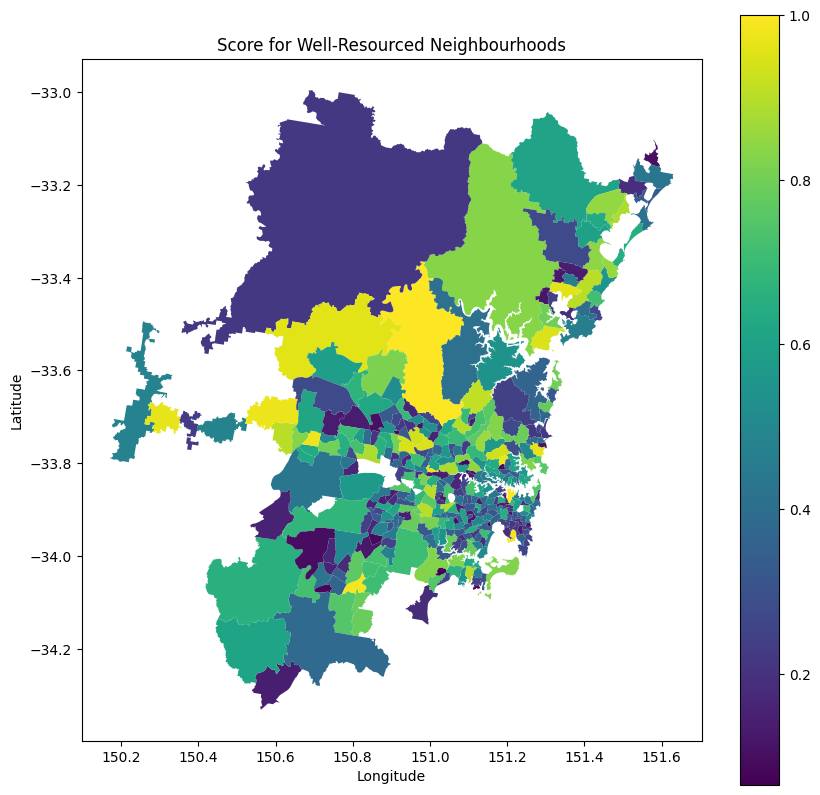

In [35]:
#Map

sa2_plot = gpd.read_postgis(sql, conn, geom_col='geom', crs='EPSG:4283')
fig, ax = plt.subplots(figsize=(10, 10))
sa2_plot.plot(column='score', cmap='viridis', legend=True, ax=ax)
plt.title('Score for Well-Resourced Neighbourhoods')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

Correlation coefficient: 0.7984070963935572


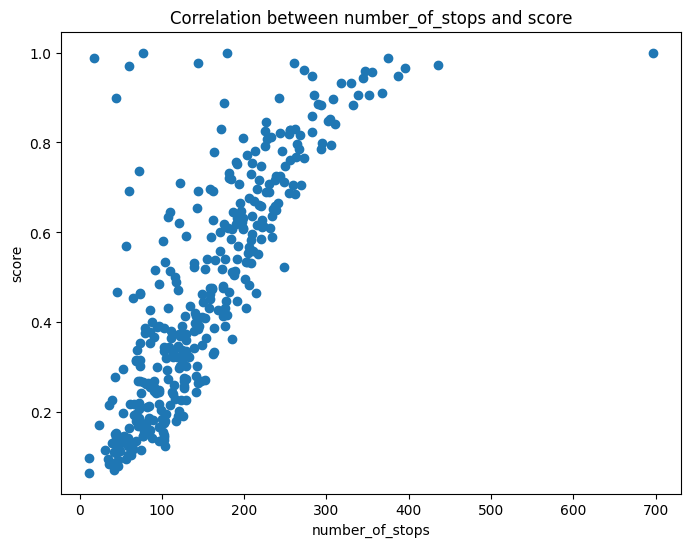

In [36]:
# Scatter plot and Correlation coefficient
correlation = sa2_plot['number_of_stops'].corr(sa2_plot['score'])
print("Correlation coefficient:", correlation)
plt.figure(figsize=(8, 6))
plt.scatter(sa2_plot['number_of_stops'], sa2_plot['score'])
plt.xlabel('number_of_stops')
plt.ylabel('score')
plt.title('Correlation between number_of_stops and score')
plt.show()

In [37]:
# sa2 with the lowest score
sql = """
WITH z_business AS (
    WITH business_per AS (
        SELECT s.sa2_code21 AS sa2_code, ROUND((CAST(b.total_businesses AS NUMERIC) * 1000 / p.total_people ),2) AS industry_business_per_1000_people 
        FROM sa2 s
        LEFT JOIN population p ON s.sa2_code21 = p.sa2_code
        LEFT JOIN business b ON s.sa2_code21 = b.sa2_code
        WHERE b.industry_name = 'Retail Trade'
        AND p.total_people >= 100
    ), 
    stats AS (
        SELECT AVG(industry_business_per_1000_people) AS average, STDDEV(industry_business_per_1000_people) AS standard_deviation
        FROM business_per
    )
    SELECT sa2_code, industry_business_per_1000_people, (industry_business_per_1000_people - average) / standard_deviation AS z_score
    FROM business_per, stats
), z_stops AS (
    WITH stop_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_stops
        FROM sa2
        LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_stops) AS average, STDDEV(number_of_stops) AS standard_deviation
        FROM stop_num
    )
    SELECT sa2_code, number_of_stops, (number_of_stops - average) / standard_deviation AS z_score
    FROM stop_num, stats
), z_polls AS (
    WITH poll_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_polling_locations
        FROM sa2
        LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_polling_locations) AS average, STDDEV(number_of_polling_locations) AS standard_deviation
        FROM poll_num
    )
    SELECT sa2_code, number_of_polling_locations, (number_of_polling_locations - average) / standard_deviation AS z_score
    FROM poll_num, stats
), z_school AS (
    WITH school_per AS (
        SELECT sa2_code21 AS sa2_code, SUM(ST_Area(school.geom::geography)) AS area, (p.people_0_4 + p.people_5_9 + p.people_10_14 + p.people_15_19) AS young_people
        FROM sa2
        LEFT JOIN population p ON sa2.sa2_code21 = p.sa2_code
        LEFT JOIN school ON ST_Intersects(sa2.geom, school.geom)
        GROUP BY sa2_code21, young_people
    ), 
    stats AS(
        SELECT AVG(area * 1000 / young_people) AS average, STDDEV(area * 1000 / young_people) AS standard_deviation
        FROM school_per
        WHERE young_people > 0
    )
    SELECT sa2_code, (area * 1000 / young_people) AS school_areas_per_1000_young_people, ((area * 1000 / young_people) - average) / standard_deviation AS z_score
    FROM school_per, stats
    WHERE young_people > 0
)
SELECT sa2.sa2_code21 AS sa2_code, sa2.sa2_name21, 1 / (1 + EXP(-(b.z_score + st.z_score + p.z_score + sc.z_score))) AS score
FROM sa2 
LEFT JOIN z_business b ON sa2.sa2_code21 = b.sa2_code
LEFT JOIN z_stops st ON sa2.sa2_code21 = st.sa2_code
LEFT JOIN z_polls p ON sa2.sa2_code21 = p.sa2_code
LEFT JOIN z_school sc ON sa2.sa2_code21 = sc.sa2_code
ORDER BY score ASC
LIMIT 1;
"""
query(conn,sql)

,sa2_code,sa2_name21,score
0,119041671,Wolli Creek,0.065203


In [38]:
# sa2 with the highest score
sql = """
WITH z_business AS (
    WITH business_per AS (
        SELECT s.sa2_code21 AS sa2_code, ROUND((CAST(b.total_businesses AS NUMERIC) * 1000 / p.total_people ),2) AS industry_business_per_1000_people 
        FROM sa2 s
        LEFT JOIN population p ON s.sa2_code21 = p.sa2_code
        LEFT JOIN business b ON s.sa2_code21 = b.sa2_code
        WHERE b.industry_name = 'Retail Trade'
        AND p.total_people >= 100
    ), 
    stats AS (
        SELECT AVG(industry_business_per_1000_people) AS average, STDDEV(industry_business_per_1000_people) AS standard_deviation
        FROM business_per
    )
    SELECT sa2_code, industry_business_per_1000_people, (industry_business_per_1000_people - average) / standard_deviation AS z_score
    FROM business_per, stats
), z_stops AS (
    WITH stop_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_stops
        FROM sa2
        LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_stops) AS average, STDDEV(number_of_stops) AS standard_deviation
        FROM stop_num
    )
    SELECT sa2_code, number_of_stops, (number_of_stops - average) / standard_deviation AS z_score
    FROM stop_num, stats
), z_polls AS (
    WITH poll_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_polling_locations
        FROM sa2
        LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_polling_locations) AS average, STDDEV(number_of_polling_locations) AS standard_deviation
        FROM poll_num
    )
    SELECT sa2_code, number_of_polling_locations, (number_of_polling_locations - average) / standard_deviation AS z_score
    FROM poll_num, stats
), z_school AS (
    WITH school_per AS (
        SELECT sa2_code21 AS sa2_code, SUM(ST_Area(school.geom::geography)) AS area, (p.people_0_4 + p.people_5_9 + p.people_10_14 + p.people_15_19) AS young_people
        FROM sa2
        LEFT JOIN population p ON sa2.sa2_code21 = p.sa2_code
        LEFT JOIN school ON ST_Intersects(sa2.geom, school.geom)
        GROUP BY sa2_code21, young_people
    ), 
    stats AS(
        SELECT AVG(area * 1000 / young_people) AS average, STDDEV(area * 1000 / young_people) AS standard_deviation
        FROM school_per
        WHERE young_people > 0
    )
    SELECT sa2_code, (area * 1000 / young_people) AS school_areas_per_1000_young_people, ((area * 1000 / young_people) - average) / standard_deviation AS z_score
    FROM school_per, stats
    WHERE young_people > 0
)
SELECT sa2.sa2_code21 AS sa2_code, sa2.sa2_name21, 1 / (1 + EXP(-(b.z_score + st.z_score + p.z_score + sc.z_score))) AS score
FROM sa2 
LEFT JOIN z_business b ON sa2.sa2_code21 = b.sa2_code
LEFT JOIN z_stops st ON sa2.sa2_code21 = st.sa2_code
LEFT JOIN z_polls p ON sa2.sa2_code21 = p.sa2_code
LEFT JOIN z_school sc ON sa2.sa2_code21 = sc.sa2_code
WHERE 1 / (1 + EXP(-(b.z_score + st.z_score + p.z_score + sc.z_score))) IS NOT NULL
ORDER BY score DESC
LIMIT 1;
"""
query(conn,sql)

,sa2_code,sa2_name21,score
0,117031644,Sydney (North) - Millers Point,1.0


Task 3

Dataset 1 - Dog_off-leash_parks

In [39]:
# Load and Clean data

dog_parks = gpd.read_file('Dog_off-leash_parks.geojson')
dog_parks['geom'] = dog_parks['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))

dog_parks = dog_parks[['OBJECTID', 'Agency', 'geom']]

dog_parks.rename(columns={'OBJECTID': 'objectid'}, inplace=True)
dog_parks.rename(columns={'Agency': 'agency'}, inplace=True)

In [40]:
# Create schema for table dog_parks
db, conn = pgconnect(credentials)
conn.execute(
    text("""
        DROP TABLE IF EXISTS dog_parks;
        CREATE TABLE dog_parks (
        objectid integer,
        agency varchar(99),
        geom GEOMETRY(POINT, 4283)
        );
    """)
)

conn.execute(text("COMMIT;"))

Connected successfully.


In [41]:
# Import data into table dog_parks
dog_parks_type = {
    'objectid' : types.Integer(),
    'geom': Geometry('POINT', srid)
}

dog_parks.to_sql('dog_parks', conn, if_exists = "replace", index = False, dtype=dog_parks_type)

conn.execute(
    text("""
            ALTER TABLE dog_parks
            ADD PRIMARY KEY (objectid);
    """)
)
conn.execute(text("COMMIT;"))

query(conn, 'select * from dog_parks')

,objectid,agency,geom
0,1,City of Sydney,0101000020BB10000019E8CA0658E76240629C30186EEF...
1,2,City of Sydney,0101000020BB10000089CDC35A3BE662407FD2F7BD26F2...
2,3,City of Sydney,0101000020BB10000046598342C3E662407BA35943BBF1...
3,4,City of Sydney,0101000020BB10000076369D7BCEE662402D1E0061B9F0...
4,5,City of Sydney,0101000020BB100000F423E0F98FE66240D0C7D94DDEF4...
5,6,Place Management NSW,0101000020BB100000A54D003346E6624087587D79D7EE...
6,7,City of Sydney,0101000020BB1000000AFA517B64E6624034FE96799FF4...
7,8,City of Sydney,0101000020BB1000002DAC78617DE66240554526F8DAED...
8,9,City of Sydney,0101000020BB10000007962622D5E662408FEF27750BF3...
9,10,City of Sydney,0101000020BB100000C1355523DFE66240DC0E975CAFF2...


Dataset 2 - Mobility_parking

In [42]:
# Load and Clean data
mob_parking = gpd.read_file('Mobility_parking.geojson')
mob_parking['geom'] = mob_parking['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))

mob_parking = mob_parking[['OBJECTID', 'geom']]

mob_parking.rename(columns={'OBJECTID': 'objectid'}, inplace=True)

In [43]:
# Create schema for table mob_parking
db, conn = pgconnect(credentials)
conn.execute(
    text("""
        DROP TABLE IF EXISTS mob_parking;
        CREATE TABLE mob_parking (
        objectid integer,
        geom GEOMETRY(POINT, 4283)
        );
    """)
)
conn.execute(text("COMMIT;"))

Connected successfully.


In [44]:
# Import data into table mob_parking
mob_parking_type = {
    'objectid' : types.Integer(),
    'geom': Geometry('POINT', srid)
}

mob_parking.to_sql('mob_parking', conn, if_exists = "replace", index = False, dtype=mob_parking_type)

conn.execute(
    text("""
            ALTER TABLE mob_parking
            ADD PRIMARY KEY (objectid);
    """)
)
conn.execute(text("COMMIT;"))

query(conn, 'select * from mob_parking')

,objectid,geom
0,1,0101000020BB100000CB366BC9A5E6624085E03A16A3ED...
1,2,0101000020BB100000B832016407E66240532853148BF3...
2,3,0101000020BB100000232B2640CBE56240EEE5ABA0CAF3...
3,4,0101000020BB100000BF03387C92E662407023D448F8F0...
4,5,0101000020BB100000DE3FFA1091E6624015DFCA237CF2...
...,...,...
311,730,0101000020BB10000001B14E2B68E6624077F70867BEF5...
312,732,0101000020BB1000009EB68AB99EE662408F62779463EE...
313,733,0101000020BB1000001C6F1AF2AFE66240097C0F2A50ED...
314,734,0101000020BB1000005B611CE14AE662404C57B75E4FF3...


Caculate z-score

In [45]:
# dog_park z-score
sql ="""
WITH dog_park_num AS (
    SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_dog_parks
    FROM sa2
    LEFT JOIN dog_parks d ON ST_Contains(sa2.geom, d.geom)
    GROUP BY sa2_code
),
stats AS (
    SELECT AVG(number_of_dog_parks) AS average, STDDEV(number_of_dog_parks) AS standard_deviation
    FROM dog_park_num
)
SELECT sa2_code, number_of_dog_parks, (number_of_dog_parks - average) / standard_deviation AS z_score
FROM dog_park_num, stats
ORDER BY sa2_code ASC;
"""

query(conn,sql)

,sa2_code,number_of_dog_parks,z_score
0,102011028,1,-0.171653
1,102011029,1,-0.171653
2,102011030,1,-0.171653
3,102011031,1,-0.171653
4,102011032,1,-0.171653
...,...,...,...
368,128021537,1,-0.171653
369,128021538,1,-0.171653
370,128021607,1,-0.171653
371,128021608,1,-0.171653


In [46]:
# mob_parking z-score
sql ="""
WITH mob_parking_num AS (
    SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_mob_parking
    FROM sa2
    LEFT JOIN mob_parking m ON ST_Contains(sa2.geom, m.geom)
    GROUP BY sa2_code
),
stats AS (
    SELECT AVG(number_of_mob_parking) AS average, STDDEV(number_of_mob_parking) AS standard_deviation
    FROM mob_parking_num
)
SELECT sa2_code, number_of_mob_parking, (number_of_mob_parking - average) / standard_deviation AS z_score
FROM mob_parking_num, stats
ORDER BY sa2_code ASC;
"""

query(conn,sql)

,sa2_code,number_of_mob_parking,z_score
0,102011028,1,-0.166181
1,102011029,1,-0.166181
2,102011030,1,-0.166181
3,102011031,1,-0.166181
4,102011032,1,-0.166181
...,...,...,...
368,128021537,1,-0.166181
369,128021538,1,-0.166181
370,128021607,1,-0.166181
371,128021608,1,-0.166181


Caculate Score (Sigmoid function of sum of z-score)

In [47]:
sql = """
WITH z_business AS (
    WITH business_per AS (
        SELECT s.sa2_code21 AS sa2_code, ROUND((CAST(b.total_businesses AS NUMERIC) * 1000 / p.total_people ),2) AS industry_business_per_1000_people 
        FROM sa2 s
        LEFT JOIN population p ON s.sa2_code21 = p.sa2_code
        LEFT JOIN business b ON s.sa2_code21 = b.sa2_code
        WHERE b.industry_name = 'Retail Trade'
        AND p.total_people >= 100
    ), 
    stats AS (
        SELECT AVG(industry_business_per_1000_people) AS average, STDDEV(industry_business_per_1000_people) AS standard_deviation
        FROM business_per
    )
    SELECT sa2_code, industry_business_per_1000_people, (industry_business_per_1000_people - average) / standard_deviation AS z_score
    FROM business_per, stats
), z_stops AS (
    WITH stop_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_stops
        FROM sa2
        LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_stops) AS average, STDDEV(number_of_stops) AS standard_deviation
        FROM stop_num
    )
    SELECT sa2_code, number_of_stops, (number_of_stops - average) / standard_deviation AS z_score
    FROM stop_num, stats
), z_polls AS (
    WITH poll_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_polling_locations
        FROM sa2
        LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_polling_locations) AS average, STDDEV(number_of_polling_locations) AS standard_deviation
        FROM poll_num
    )
    SELECT sa2_code, number_of_polling_locations, (number_of_polling_locations - average) / standard_deviation AS z_score
    FROM poll_num, stats
), z_school AS (
    WITH school_per AS (
        SELECT sa2_code21 AS sa2_code, SUM(ST_Area(school.geom::geography)) AS area, (p.people_0_4 + p.people_5_9 + p.people_10_14 + p.people_15_19) AS young_people
        FROM sa2
        LEFT JOIN population p ON sa2.sa2_code21 = p.sa2_code
        LEFT JOIN school ON ST_Intersects(sa2.geom, school.geom)
        GROUP BY sa2_code21, young_people
    ), 
    stats AS(
        SELECT AVG(area * 1000 / young_people) AS average, STDDEV(area * 1000 / young_people) AS standard_deviation
        FROM school_per
        WHERE young_people > 0
    )
    SELECT sa2_code, (area * 1000 / young_people) AS school_areas_per_1000_young_people, ((area * 1000 / young_people) - average) / standard_deviation AS z_score
    FROM school_per, stats
    WHERE young_people > 0
), z_dog_parks AS (
    WITH dog_park_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_dog_parks
        FROM sa2
        LEFT JOIN dog_parks d ON ST_Contains(sa2.geom, d.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_dog_parks) AS average, STDDEV(number_of_dog_parks) AS standard_deviation
        FROM dog_park_num
    )
    SELECT sa2_code, number_of_dog_parks, (number_of_dog_parks - average) / standard_deviation AS z_score
    FROM dog_park_num, stats
), z_mob_parking AS (
    WITH mob_parking_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_mob_parking
        FROM sa2
        LEFT JOIN mob_parking m ON ST_Contains(sa2.geom, m.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_mob_parking) AS average, STDDEV(number_of_mob_parking) AS standard_deviation
        FROM mob_parking_num
    )
    SELECT sa2_code, number_of_mob_parking, (number_of_mob_parking - average) / standard_deviation AS z_score
    FROM mob_parking_num, stats
)
SELECT sa2.sa2_code21 AS sa2_code, b.z_score AS business_z_score, st.z_score AS stops_z_score, p.z_score AS polls_z_score, sc.z_score AS school_z_score, d.z_score AS dog_parks_z_score, m.z_score AS mob_parking_z_score, m.number_of_mob_parking, 1 / (1 + EXP(-(b.z_score + st.z_score + p.z_score + sc.z_score + d.z_score + m.z_score))) AS score, sa2.geom
FROM sa2 
LEFT JOIN z_business b ON sa2.sa2_code21 = b.sa2_code
LEFT JOIN z_stops st ON sa2.sa2_code21 = st.sa2_code
LEFT JOIN z_polls p ON sa2.sa2_code21 = p.sa2_code
LEFT JOIN z_school sc ON sa2.sa2_code21 = sc.sa2_code
LEFT JOIN z_dog_parks d ON sa2.sa2_code21 = d.sa2_code
LEFT JOIN z_mob_parking m ON sa2.sa2_code21 = m.sa2_code
ORDER BY sa2_code ASC;
"""
query(conn,sql)

,sa2_code,business_z_score,stops_z_score,polls_z_score,school_z_score,dog_parks_z_score,mob_parking_z_score,number_of_mob_parking,score,geom
0,102011028,-0.148092,-0.258172,-0.520428,-0.077199,-0.171653,-0.166181,1,0.207226,0106000020BB100000010000000103000000010000005E...
1,102011029,-0.300911,0.758290,-0.520428,-0.075416,-0.171653,-0.166181,1,0.383126,0106000020BB1000000100000001030000000100000010...
2,102011030,0.483073,0.261610,0.705075,0.133947,-0.171653,-0.166181,1,0.776584,0106000020BB1000000200000001030000000100000085...
3,102011031,0.300946,1.566840,0.459974,-0.075170,-0.171653,-0.166181,1,0.871552,0106000020BB1000000100000001030000000100000041...
4,102011032,0.108352,2.375389,0.705075,-0.073717,-0.171653,-0.166181,1,0.941435,0106000020BB100000010000000103000000010000007E...
...,...,...,...,...,...,...,...,...,...,...
368,128021537,NaN,-1.390142,-0.765529,0.595342,-0.171653,-0.166181,1,NaN,0106000020BB1000000100000001030000000100000046...
369,128021538,-0.218221,0.527276,0.459974,-0.078193,-0.171653,-0.166181,1,0.587345,0106000020BB1000000100000001030000000100000089...
370,128021607,-0.364760,0.827594,0.705075,-0.077427,-0.171653,-0.166181,1,0.679755,0106000020BB100000010000000103000000010000008E...
371,128021608,-0.361620,-0.061810,-0.520428,-0.077769,-0.171653,-0.166181,1,0.204328,0106000020BB10000001000000010300000001000000A1...


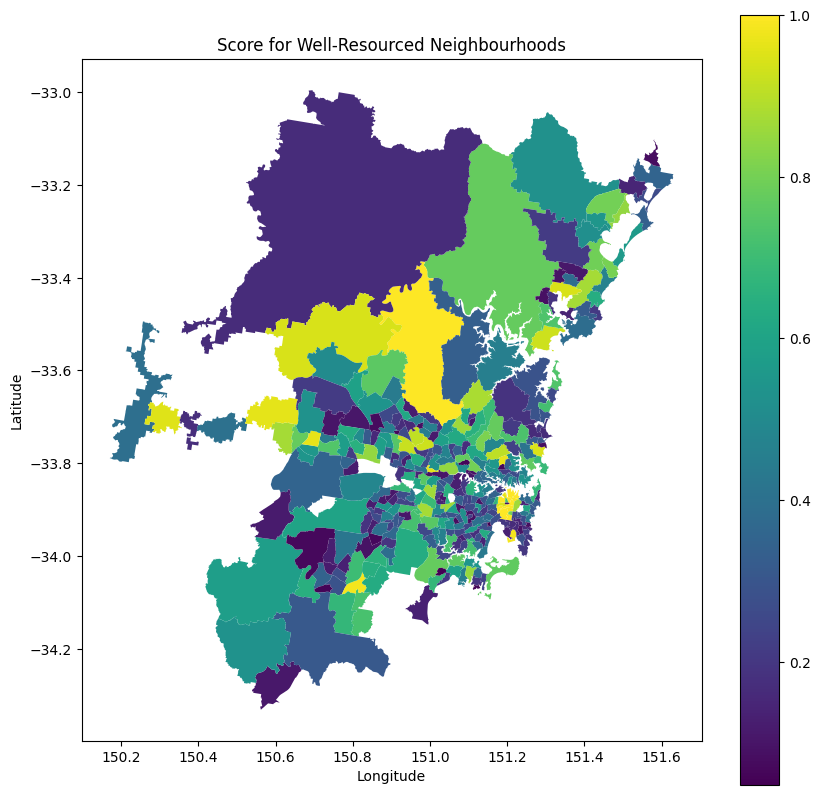

In [48]:
# Map
import matplotlib.pyplot as plt
sa2_plot = gpd.read_postgis(sql, conn, geom_col='geom', crs='EPSG:4283')
fig, ax = plt.subplots(figsize=(10, 10))
sa2_plot.plot(column='score', cmap='viridis', legend=True, ax=ax)
plt.title('Score for Well-Resourced Neighbourhoods')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

Correlation coefficient: 0.33856588327207154


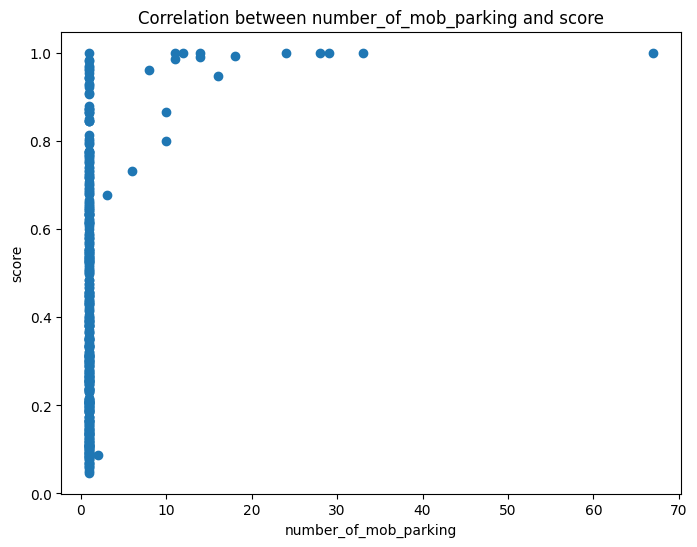

In [49]:
# Scatter plot
correlation = sa2_plot['number_of_mob_parking'].corr(sa2_plot['score'])
print("Correlation coefficient:", correlation)
plt.figure(figsize=(8, 6))
plt.scatter(sa2_plot['number_of_mob_parking'], sa2_plot['score'])
plt.xlabel('number_of_mob_parking')
plt.ylabel('score')
plt.title('Correlation between number_of_mob_parking and score')
plt.show()

In [50]:
# sa2 with the lowest score
sql = """
WITH z_business AS (
    WITH business_per AS (
        SELECT s.sa2_code21 AS sa2_code, ROUND((CAST(b.total_businesses AS NUMERIC) * 1000 / p.total_people ),2) AS industry_business_per_1000_people 
        FROM sa2 s
        LEFT JOIN population p ON s.sa2_code21 = p.sa2_code
        LEFT JOIN business b ON s.sa2_code21 = b.sa2_code
        WHERE b.industry_name = 'Retail Trade'
        AND p.total_people >= 100
    ), 
    stats AS (
        SELECT AVG(industry_business_per_1000_people) AS average, STDDEV(industry_business_per_1000_people) AS standard_deviation
        FROM business_per
    )
    SELECT sa2_code, industry_business_per_1000_people, (industry_business_per_1000_people - average) / standard_deviation AS z_score
    FROM business_per, stats
), z_stops AS (
    WITH stop_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_stops
        FROM sa2
        LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_stops) AS average, STDDEV(number_of_stops) AS standard_deviation
        FROM stop_num
    )
    SELECT sa2_code, number_of_stops, (number_of_stops - average) / standard_deviation AS z_score
    FROM stop_num, stats
), z_polls AS (
    WITH poll_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_polling_locations
        FROM sa2
        LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_polling_locations) AS average, STDDEV(number_of_polling_locations) AS standard_deviation
        FROM poll_num
    )
    SELECT sa2_code, number_of_polling_locations, (number_of_polling_locations - average) / standard_deviation AS z_score
    FROM poll_num, stats
), z_school AS (
    WITH school_per AS (
        SELECT sa2_code21 AS sa2_code, SUM(ST_Area(school.geom::geography)) AS area, (p.people_0_4 + p.people_5_9 + p.people_10_14 + p.people_15_19) AS young_people
        FROM sa2
        LEFT JOIN population p ON sa2.sa2_code21 = p.sa2_code
        LEFT JOIN school ON ST_Intersects(sa2.geom, school.geom)
        GROUP BY sa2_code21, young_people
    ), 
    stats AS(
        SELECT AVG(area * 1000 / young_people) AS average, STDDEV(area * 1000 / young_people) AS standard_deviation
        FROM school_per
        WHERE young_people > 0
    )
    SELECT sa2_code, (area * 1000 / young_people) AS school_areas_per_1000_young_people, ((area * 1000 / young_people) - average) / standard_deviation AS z_score
    FROM school_per, stats
    WHERE young_people > 0
), z_dog_parks AS (
    WITH dog_park_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_dog_parks
        FROM sa2
        LEFT JOIN dog_parks d ON ST_Contains(sa2.geom, d.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_dog_parks) AS average, STDDEV(number_of_dog_parks) AS standard_deviation
        FROM dog_park_num
    )
    SELECT sa2_code, number_of_dog_parks, (number_of_dog_parks - average) / standard_deviation AS z_score
    FROM dog_park_num, stats
), z_mob_parking AS (
    WITH mob_parking_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_mob_parking
        FROM sa2
        LEFT JOIN mob_parking m ON ST_Contains(sa2.geom, m.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_mob_parking) AS average, STDDEV(number_of_mob_parking) AS standard_deviation
        FROM mob_parking_num
    )
    SELECT sa2_code, number_of_mob_parking, (number_of_mob_parking - average) / standard_deviation AS z_score
    FROM mob_parking_num, stats
)
SELECT sa2.sa2_code21 AS sa2_code, sa2.sa2_name21, 1 / (1 + EXP(-(b.z_score + st.z_score + p.z_score + sc.z_score + d.z_score + m.z_score))) AS score, sa2.geom
FROM sa2 
LEFT JOIN z_business b ON sa2.sa2_code21 = b.sa2_code
LEFT JOIN z_stops st ON sa2.sa2_code21 = st.sa2_code
LEFT JOIN z_polls p ON sa2.sa2_code21 = p.sa2_code
LEFT JOIN z_school sc ON sa2.sa2_code21 = sc.sa2_code
LEFT JOIN z_dog_parks d ON sa2.sa2_code21 = d.sa2_code
LEFT JOIN z_mob_parking m ON sa2.sa2_code21 = m.sa2_code
ORDER BY score ASC
LIMIT 1;
"""
query(conn,sql)

,sa2_code,sa2_name21,score,geom
0,119041671,Wolli Creek,0.047396,0106000020BB1000000100000001030000000100000095...


In [51]:
# sa2 with the highest score
sql = """
WITH z_business AS (
    WITH business_per AS (
        SELECT s.sa2_code21 AS sa2_code, ROUND((CAST(b.total_businesses AS NUMERIC) * 1000 / p.total_people ),2) AS industry_business_per_1000_people 
        FROM sa2 s
        LEFT JOIN population p ON s.sa2_code21 = p.sa2_code
        LEFT JOIN business b ON s.sa2_code21 = b.sa2_code
        WHERE b.industry_name = 'Retail Trade'
        AND p.total_people >= 100
    ), 
    stats AS (
        SELECT AVG(industry_business_per_1000_people) AS average, STDDEV(industry_business_per_1000_people) AS standard_deviation
        FROM business_per
    )
    SELECT sa2_code, industry_business_per_1000_people, (industry_business_per_1000_people - average) / standard_deviation AS z_score
    FROM business_per, stats
), z_stops AS (
    WITH stop_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_stops
        FROM sa2
        LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_stops) AS average, STDDEV(number_of_stops) AS standard_deviation
        FROM stop_num
    )
    SELECT sa2_code, number_of_stops, (number_of_stops - average) / standard_deviation AS z_score
    FROM stop_num, stats
), z_polls AS (
    WITH poll_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_polling_locations
        FROM sa2
        LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_polling_locations) AS average, STDDEV(number_of_polling_locations) AS standard_deviation
        FROM poll_num
    )
    SELECT sa2_code, number_of_polling_locations, (number_of_polling_locations - average) / standard_deviation AS z_score
    FROM poll_num, stats
), z_school AS (
    WITH school_per AS (
        SELECT sa2_code21 AS sa2_code, SUM(ST_Area(school.geom::geography)) AS area, (p.people_0_4 + p.people_5_9 + p.people_10_14 + p.people_15_19) AS young_people
        FROM sa2
        LEFT JOIN population p ON sa2.sa2_code21 = p.sa2_code
        LEFT JOIN school ON ST_Intersects(sa2.geom, school.geom)
        GROUP BY sa2_code21, young_people
    ), 
    stats AS(
        SELECT AVG(area * 1000 / young_people) AS average, STDDEV(area * 1000 / young_people) AS standard_deviation
        FROM school_per
        WHERE young_people > 0
    )
    SELECT sa2_code, (area * 1000 / young_people) AS school_areas_per_1000_young_people, ((area * 1000 / young_people) - average) / standard_deviation AS z_score
    FROM school_per, stats
    WHERE young_people > 0
), z_dog_parks AS (
    WITH dog_park_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_dog_parks
        FROM sa2
        LEFT JOIN dog_parks d ON ST_Contains(sa2.geom, d.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_dog_parks) AS average, STDDEV(number_of_dog_parks) AS standard_deviation
        FROM dog_park_num
    )
    SELECT sa2_code, number_of_dog_parks, (number_of_dog_parks - average) / standard_deviation AS z_score
    FROM dog_park_num, stats
), z_mob_parking AS (
    WITH mob_parking_num AS (
        SELECT sa2.sa2_code21 AS sa2_code, COUNT(sa2.sa2_code21) AS number_of_mob_parking
        FROM sa2
        LEFT JOIN mob_parking m ON ST_Contains(sa2.geom, m.geom)
        GROUP BY sa2_code
    ),
    stats AS (
        SELECT AVG(number_of_mob_parking) AS average, STDDEV(number_of_mob_parking) AS standard_deviation
        FROM mob_parking_num
    )
    SELECT sa2_code, number_of_mob_parking, (number_of_mob_parking - average) / standard_deviation AS z_score
    FROM mob_parking_num, stats
)
SELECT sa2.sa2_code21 AS sa2_code, sa2.sa2_name21, 1 / (1 + EXP(-(b.z_score + st.z_score + p.z_score + sc.z_score + d.z_score + m.z_score))) AS score, sa2.geom
FROM sa2 
LEFT JOIN z_business b ON sa2.sa2_code21 = b.sa2_code
LEFT JOIN z_stops st ON sa2.sa2_code21 = st.sa2_code
LEFT JOIN z_polls p ON sa2.sa2_code21 = p.sa2_code
LEFT JOIN z_school sc ON sa2.sa2_code21 = sc.sa2_code
LEFT JOIN z_dog_parks d ON sa2.sa2_code21 = d.sa2_code
LEFT JOIN z_mob_parking m ON sa2.sa2_code21 = m.sa2_code
WHERE 1 / (1 + EXP(-(b.z_score + st.z_score + p.z_score + sc.z_score + d.z_score + m.z_score))) IS NOT NULL
ORDER BY score DESC
LIMIT 1;
"""
query(conn,sql)

,sa2_code,sa2_name21,score,geom
0,117031644,Sydney (North) - Millers Point,1.0,0106000020BB100000030000000103000000010000000E...


In [52]:
# index used
sql = """
select * from pg_indexes where schemaname = 'public';
"""

df_index = pd.DataFrame(query(conn,sql))
for i in df_index["indexdef"]:
    print(i)

CREATE UNIQUE INDEX spatial_ref_sys_pkey ON public.spatial_ref_sys USING btree (srid)
CREATE INDEX idx_sa2_geom ON public.sa2 USING gist (geom)
CREATE UNIQUE INDEX sa2_pkey ON public.sa2 USING btree (sa2_code21)
CREATE UNIQUE INDEX business_pkey ON public.business USING btree (id)
CREATE INDEX idx_stops_geom ON public.stops USING gist (geom)
CREATE UNIQUE INDEX stops_pkey ON public.stops USING btree (stop_id)
CREATE INDEX idx_polls_geom ON public.polls USING gist (geom)
CREATE UNIQUE INDEX polls_pkey ON public.polls USING btree (fid)
CREATE UNIQUE INDEX population_pkey ON public.population USING btree (sa2_code)
CREATE UNIQUE INDEX income_pkey ON public.income USING btree (sa2_code21)
CREATE INDEX idx_school_geom ON public.school USING gist (geom)
CREATE UNIQUE INDEX school_pkey ON public.school USING btree (use_id)
CREATE INDEX idx_bsa2_code ON public.business USING btree (sa2_code)
CREATE INDEX idx_psa2_code ON public.population USING btree (sa2_code)
CREATE INDEX idx_dog_parks_geom 